In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
from scipy.stats import boxcox
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LassoCV, LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
train_data = pd.read_csv(r"train_data.csv")

In [3]:
train_data.shape

(8523, 12)

In [4]:
train_data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [5]:
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [6]:
train_data.Outlet_Type.nunique()

4

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [8]:
train_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Shows which fields have missing values in them

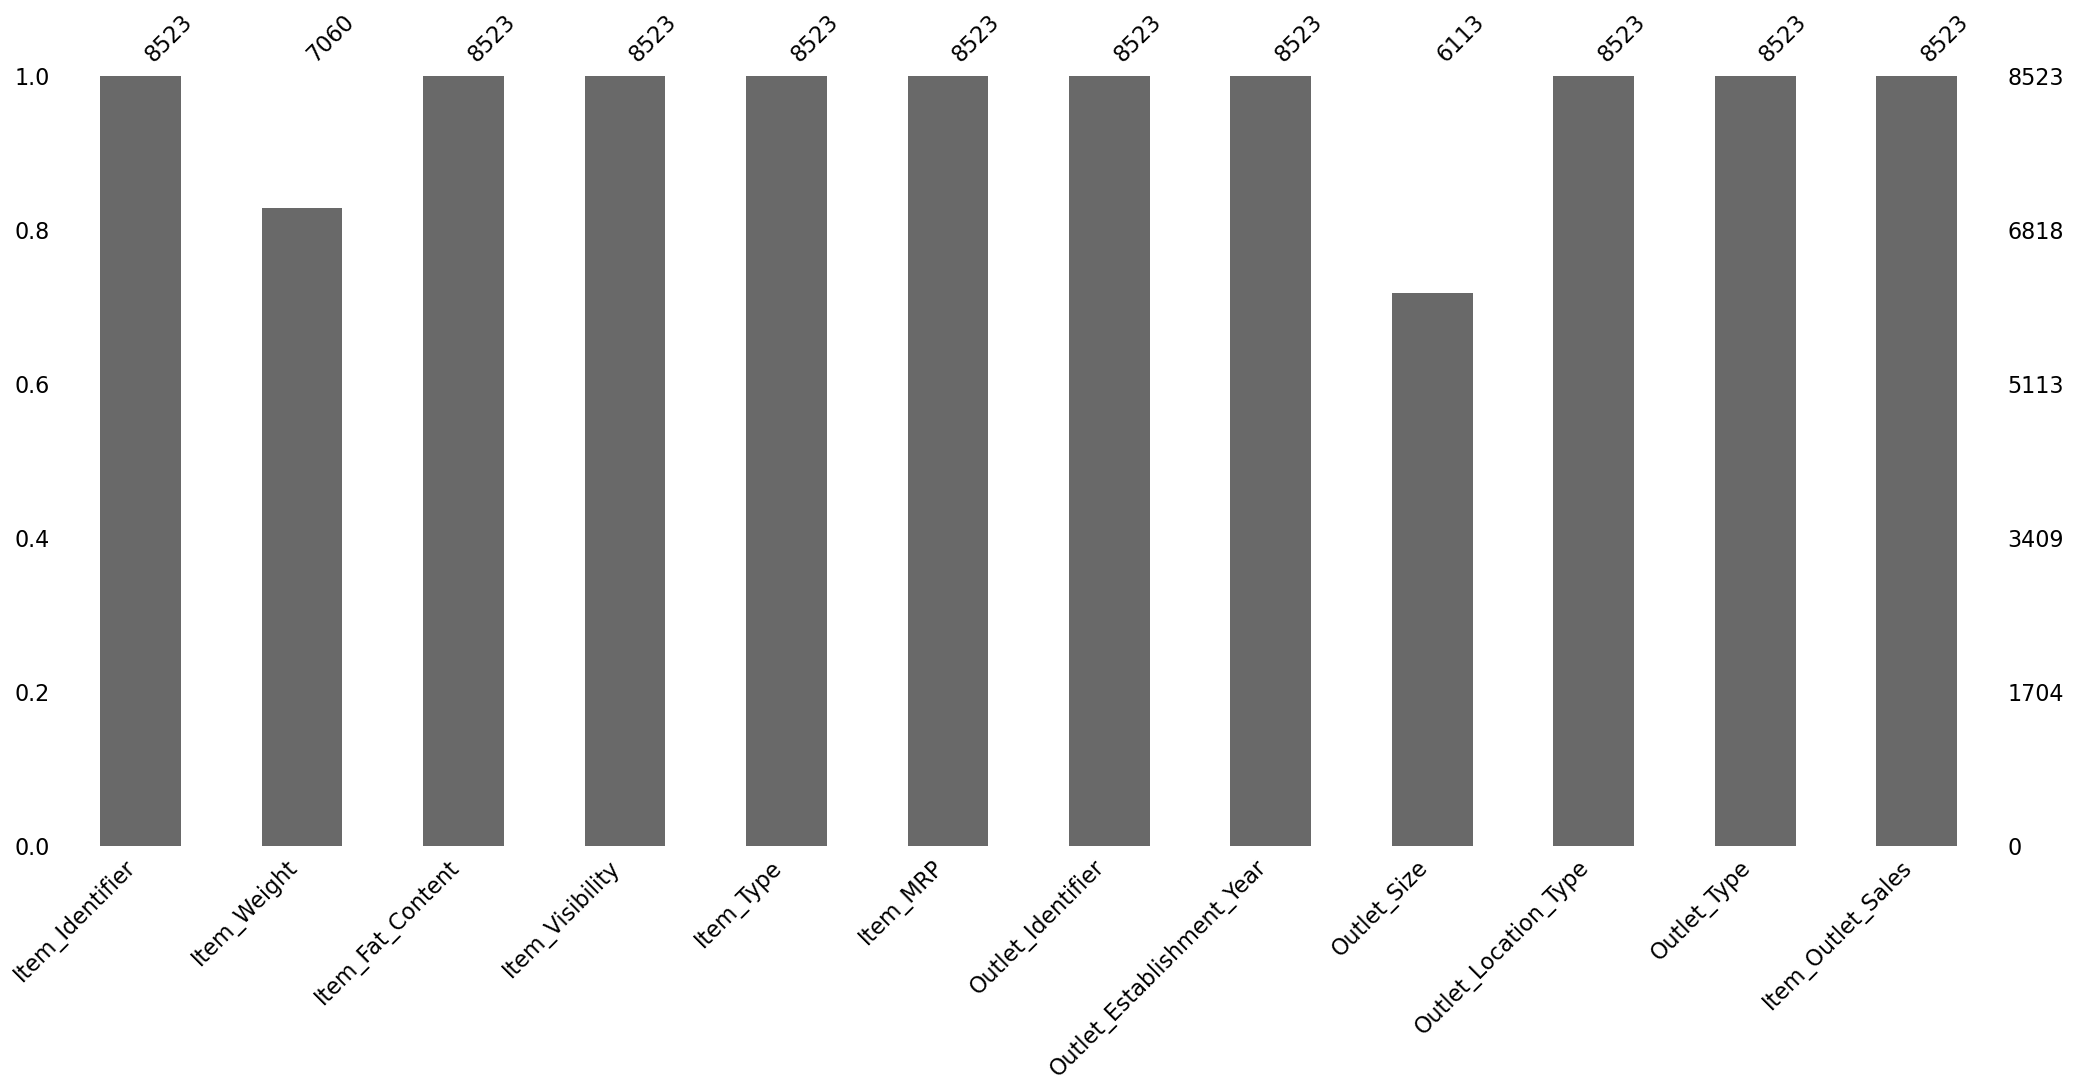

In [9]:
msno.bar(train_data)
plt.show()

Histogram shows the frequency of sales and the KDE shows the distribution

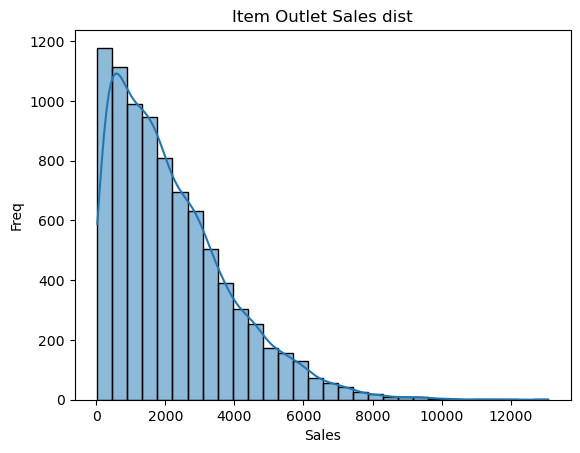

In [10]:
sns.histplot(train_data['Item_Outlet_Sales'], bins = 30, kde = True)
plt.title('Item Outlet Sales dist')
plt.xlabel("Sales")
plt.ylabel("Freq")
plt.show()

Boxplot to see how the target variable is distributed

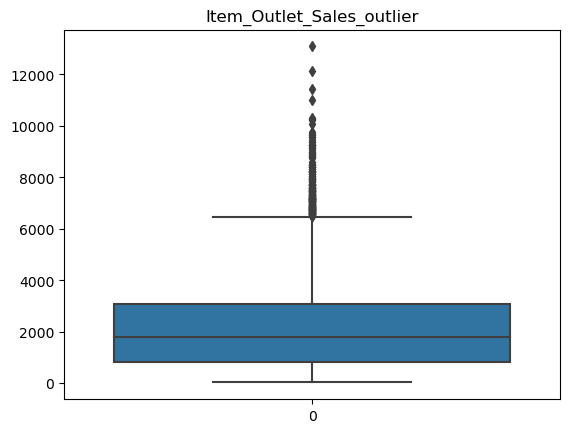

In [11]:
sns.boxplot(train_data['Item_Outlet_Sales'])
plt.title("Item_Outlet_Sales_outlier")
plt.show()

In [12]:
train_data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [13]:
train_data['Item_Fat_Content'] = train_data['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'
})

In [14]:
cat_cols = ['Item_Fat_Content','Outlet_Size','Outlet_Location_Type','Outlet_Type']

We are checking the value count to see if there is requirement to merge any of the category with the other. If any category was less than 5% of the total data values then it would be right candidate for merging with larger category

In [15]:
for col in cat_cols:
    print(f"\n{col} Value Counts:\n", train_data[col].value_counts(normalize=True) * 100)


Item_Fat_Content Value Counts:
 Low Fat    64.730729
Regular    35.269271
Name: Item_Fat_Content, dtype: float64

Outlet_Size Value Counts:
 Medium    45.689514
Small     39.064289
High      15.246197
Name: Outlet_Size, dtype: float64

Outlet_Location_Type Value Counts:
 Tier 3    39.305409
Tier 2    32.676288
Tier 1    28.018303
Name: Outlet_Location_Type, dtype: float64

Outlet_Type Value Counts:
 Supermarket Type1    65.434706
Grocery Store        12.706793
Supermarket Type3    10.970316
Supermarket Type2    10.888185
Name: Outlet_Type, dtype: float64


The count plot here generates the counts for the category columns listed above

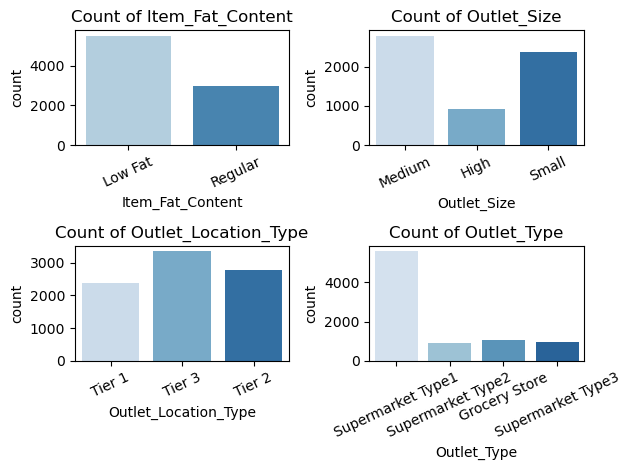

In [16]:
for i, col in enumerate(cat_cols):
    plt.subplot(2,2,i+1)
    sns.countplot(data = train_data, x = col, palette = 'Blues')
    plt.title(f"Count of {col}")
    plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

Box plot to vizualize the distribution of the category values and to observe the outliers

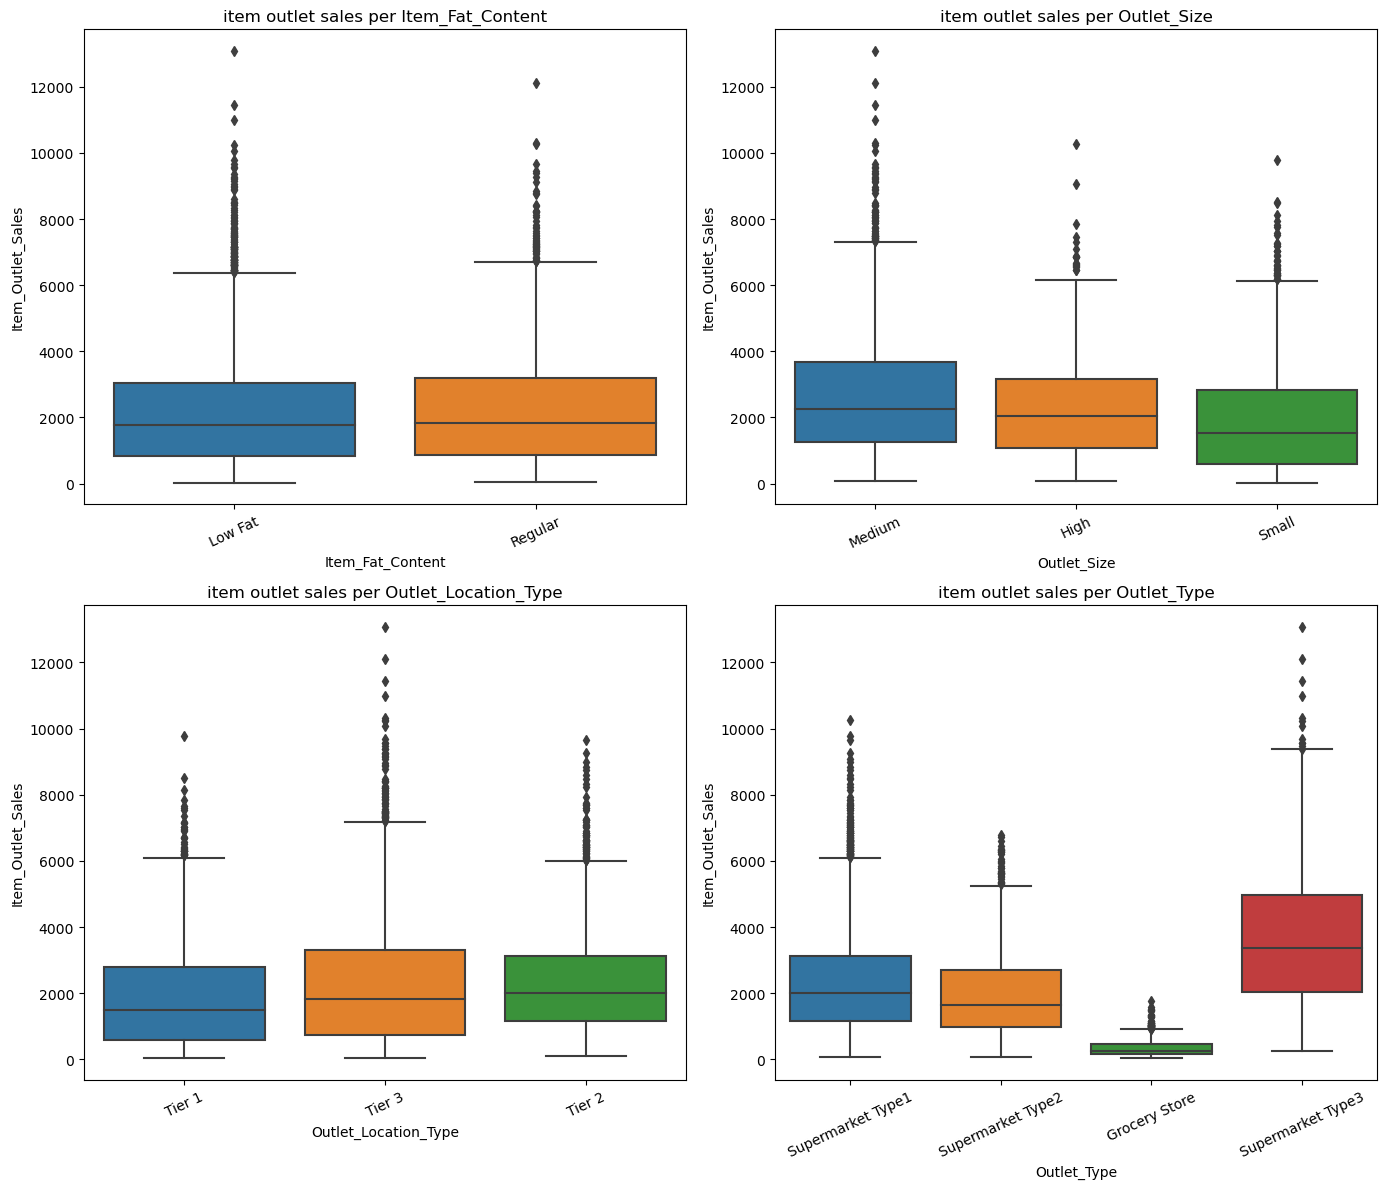

In [17]:
plt.figure(figsize = (14,12))
for i, col in enumerate(cat_cols):
    plt.subplot(2,2,i+1)
    sns.boxplot(x = train_data[col], y = train_data['Item_Outlet_Sales'])
    plt.title(f"item outlet sales per {col}")
    plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

In [18]:
train_data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

Pairplot shows the relationship between two fields

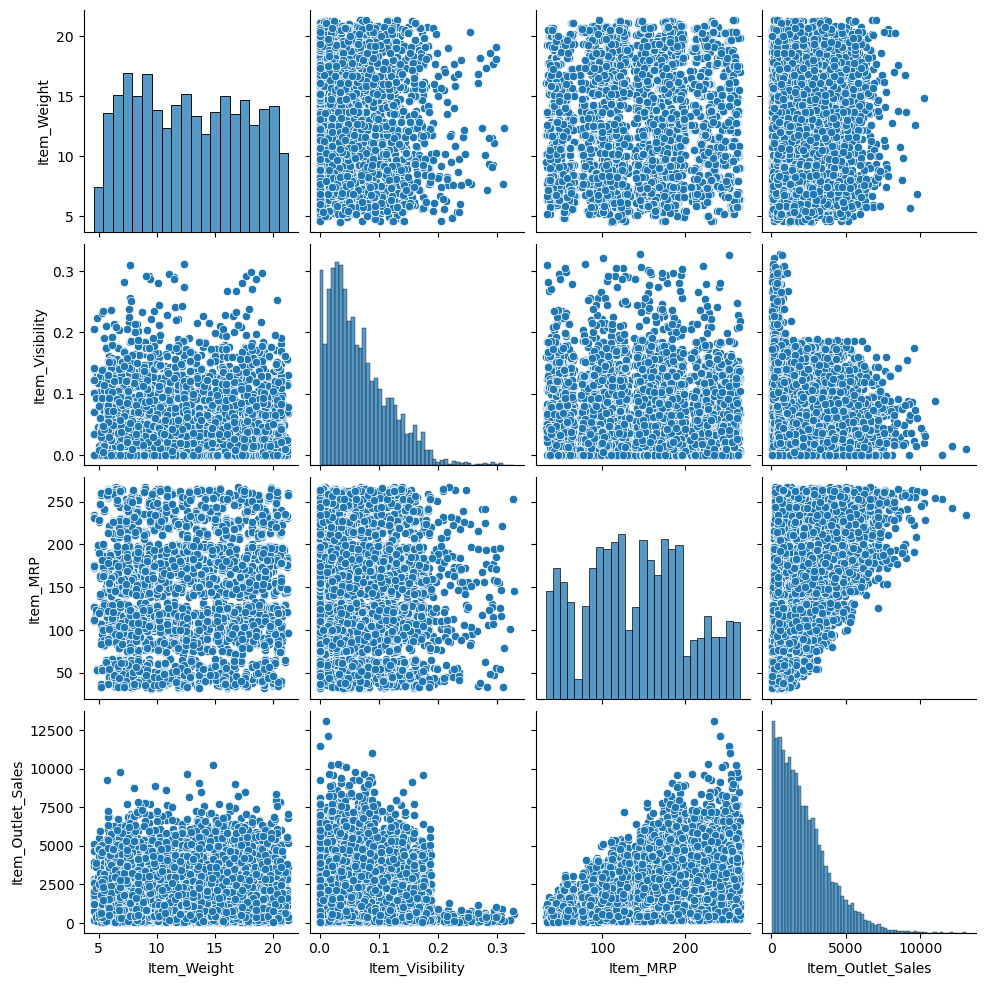

In [19]:
sns.pairplot(train_data[['Item_Weight','Item_Visibility','Item_MRP','Item_Outlet_Sales']])

Correlation plot to check if the fields are correlated with eachother and if it is a positive or negative correlation

C:\Users\vinut\AppData\Local\Temp\ipykernel_24320\2562383191.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(), annot = True, cmap = 'Blues',fmt = ".2f")


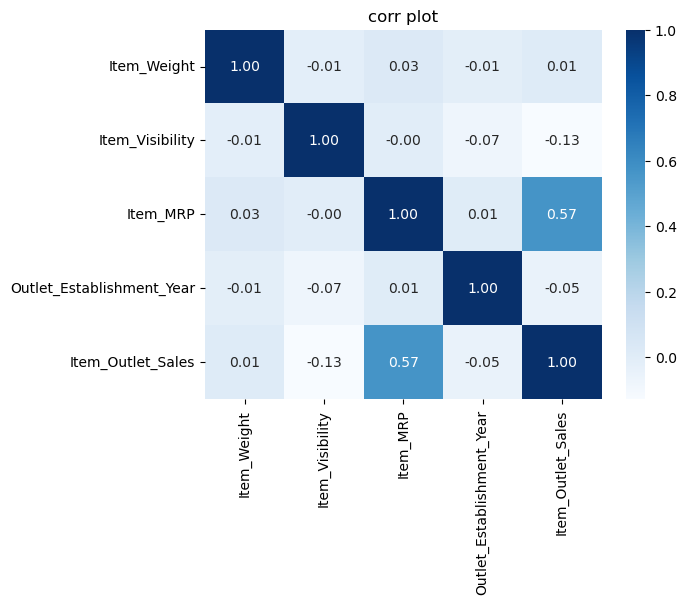

In [20]:
sns.heatmap(train_data.corr(), annot = True, cmap = 'Blues',fmt = ".2f")
plt.title("corr plot")
plt.show()

Using Scatterplot to separately check if the Item Visibility and Sales are correlated

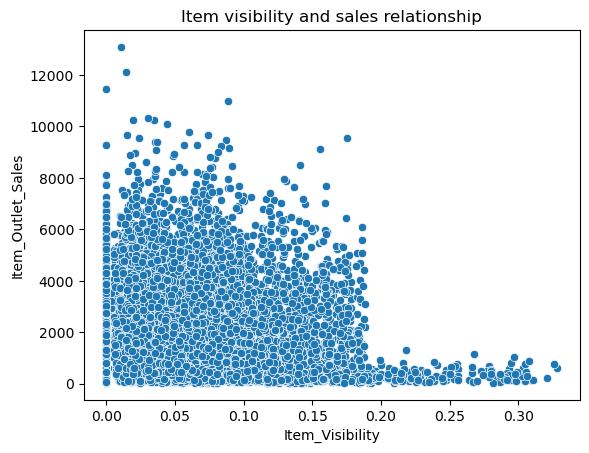

In [21]:
sns.scatterplot(x = train_data['Item_Visibility'], y = train_data['Item_Outlet_Sales'])
plt.title("Item visibility and sales relationship")
plt.show()

The below barplot shows the relationship between Item type and the outlet sales, shows what category of the product is contributing to more sales. We can see that baking goods & Others are low contributors. We can think of pricing strategies or marketing and campaign strategies for the same

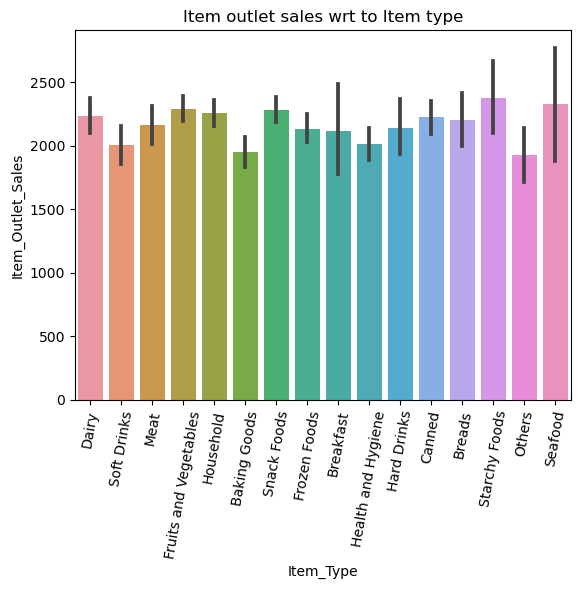

In [22]:
sns.barplot(data = train_data, x = 'Item_Type', y = "Item_Outlet_Sales")
plt.xticks(rotation = 80)
plt.title("Item outlet sales wrt to Item type")
plt.show()

In [23]:
train_data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [24]:
train_data['Outlet_Business_Years']=2025-train_data['Outlet_Establishment_Year']

From the below line chart we can see that the newer stores are having better sales than the ones which are established before 20 years. We can work on introduing better marketing or revamping the older stores 


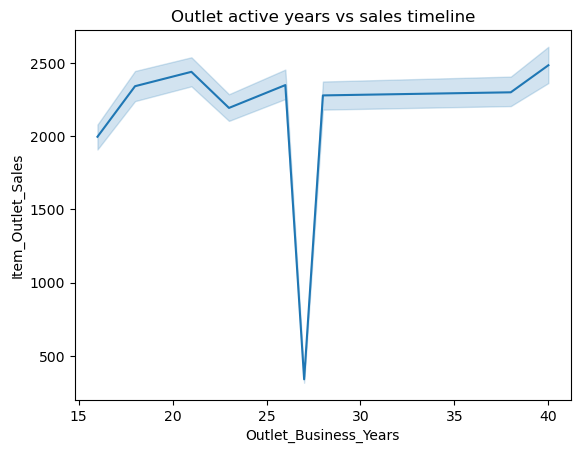

In [25]:
sns.lineplot(x=train_data['Outlet_Business_Years'], y = train_data['Item_Outlet_Sales'])
plt.title("Outlet active years vs sales timeline")
plt.show()

In [26]:
#Preprocessing train + test data for encoding and uniform preprocessing

In [27]:
test = pd.read_csv(r"test_data.csv")

In [28]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [29]:
test.isna().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [30]:
train_data.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
Outlet_Business_Years           0
dtype: int64

In [31]:
train_data['data_type'] = 'Train_data'
test['data_type'] = 'Test_data'
data = pd.concat([train_data,test],ignore_index = True)

In [32]:
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Outlet_Business_Years
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914,27.168133
std,4.652502,0.051459,62.086938,8.371664,1706.499616,8.371760
min,4.555000,0.000000,31.290000,1985.000000,33.290000,16.000000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400,21.000000
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000,26.000000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400,38.000000
max,21.350000,0.328391,266.888400,2009.000000,13086.964800,40.000000


In [33]:
data.isna().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
Outlet_Business_Years        5681
data_type                       0
dtype: int64

In [34]:
data.drop(columns = 'Outlet_Business_Years', axis = 1, inplace = True)

Missing Value Handling

In [35]:
data['Item_Weight']= data.groupby('Item_Identifier')['Item_Weight'].transform(lambda x: x.fillna(x.median()))

The below countplot tells us the count of the stores in the outlet type

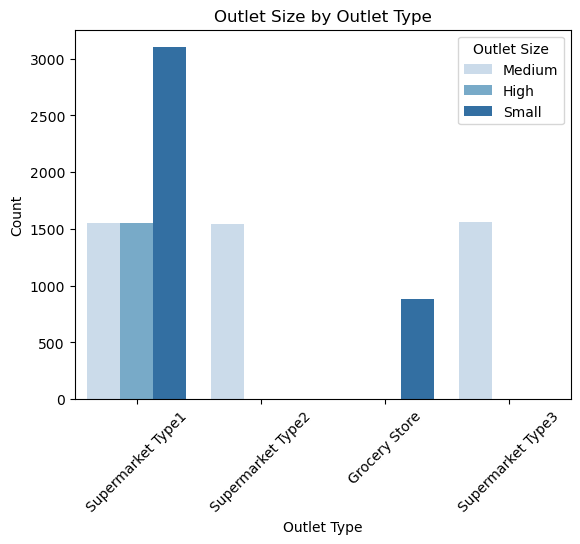

In [36]:
sns.countplot(data = data, x = 'Outlet_Type', hue = 'Outlet_Size', palette = 'Blues')
plt.title('Outlet Size by Outlet Type')
plt.xlabel('Outlet Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Outlet Size')
plt.show()

In [37]:
outletsize_type = data.groupby('Outlet_Type')['Outlet_Size'].agg(lambda x:x.mode()[0])

We can see the size of the most stores under each outlet type here

In [38]:
outletsize_type

Outlet_Type
Grocery Store         Small
Supermarket Type1     Small
Supermarket Type2    Medium
Supermarket Type3    Medium
Name: Outlet_Size, dtype: object

We make use of the above deduced values to fill the outlet size if there are blanks

In [39]:
data['Outlet_Size'] = data.apply(lambda x: outletsize_type[x['Outlet_Type']] if pd.isnull(x['Outlet_Size']) else x['Outlet_Size'], axis = 1)

In [40]:
data.isna().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
data_type                       0
dtype: int64

Visibility cannot be zero, as display area cannot be zero and hence trying to replace the blanks which could be data collection with median.
Since, visibility is right skewed (Observed from the prior studied visualization) we will use median instead of mean, as mean is not robust to the skewed data. Also, median maintains same distributtion of the data

In [41]:
median_visibility = data.groupby('Item_Type')['Item_Visibility'].median()

data.loc[data['Item_Visibility'] == 0, 'Item_Visibility'] = data['Item_Type'].map(median_visibility)

In [42]:
data["Item_Visibility_BoxCox"], _ = boxcox(data["Item_Visibility"] + 1)
data["Item_Visibility_Log"] = np.log1p(data["Item_Visibility"])

In [43]:
numerical_features = data.select_dtypes(include=['number']).columns.tolist()
numerical_features.remove("Item_Outlet_Sales")

numerical_features

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Visibility_BoxCox',
 'Item_Visibility_Log']

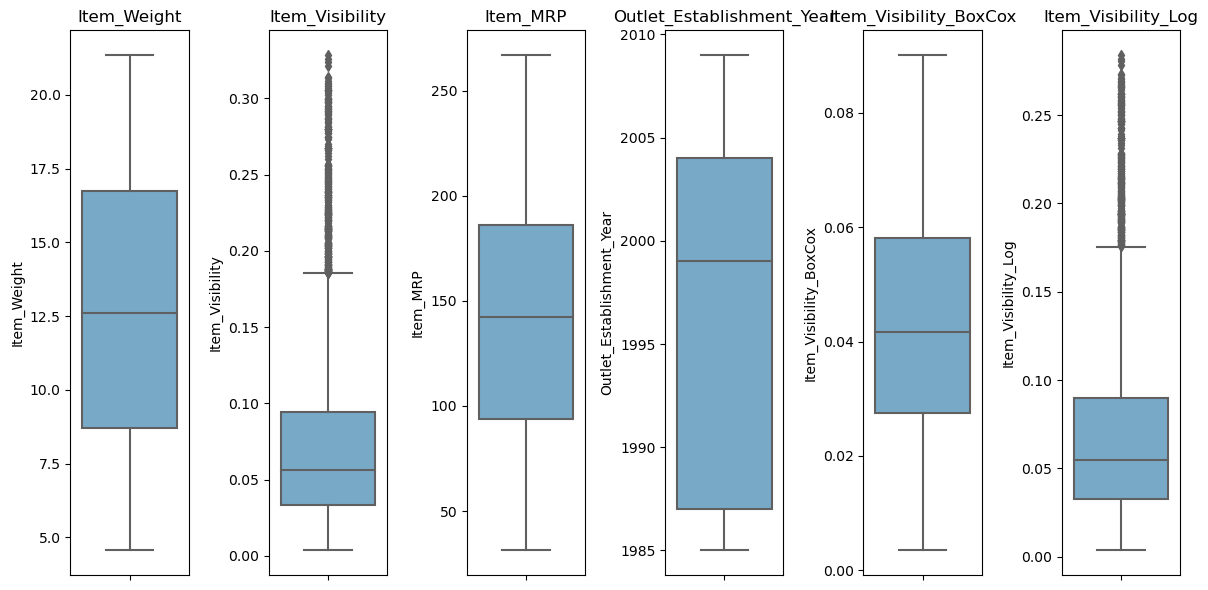

In [44]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(1, len(numerical_features), i)
    sns.boxplot(y=data[col], palette="Blues")
    plt.title(f'{col}')
plt.tight_layout()
plt.show()

In [45]:
data.Item_Fat_Content.unique()

array(['Low Fat', 'Regular', 'reg', 'LF', 'low fat'], dtype=object)

In [46]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    'low fat': 'Low Fat',
    'LF': 'Low Fat',
    'reg': 'Regular'
})

In [47]:
data.Item_Fat_Content.unique()

array(['Low Fat', 'Regular'], dtype=object)

In [48]:
#Label encoder to make sure there is order in the encoding
label_encoder = LabelEncoder()
data['Outlet_Size'] = label_encoder.fit_transform(data['Outlet_Size'])
data['Outlet_Location_Type'] = label_encoder.fit_transform(data['Outlet_Location_Type'])
data['Outlet_Type'] = label_encoder.fit_transform(data['Outlet_Type'])
data['Item_Fat_Content'] = label_encoder.fit_transform(data['Item_Fat_Content'])

In [49]:
data['Item_Type'].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

By clubbing the Item Type we can group the items to food, non food and drinks which will reduce the cardinality in the daat

In [50]:
def unify_item(item):
    if item in ['Dairy', 'Meat', 'Fruits and Vegetables', 
                'Breakfast', 'Seafood','Starchy Foods','Baking Goods', 'Snack Foods', 'Frozen Foods',
               'Canned','Breads']:
        return 'Food'
    elif item in ['Household', 'Health and Hygiene','Others']:
        return 'Non-Food'
    else:
        return 'Drinks'
data['Item_Category'] = data['Item_Type'].apply(unify_item)
data = pd.get_dummies(data, columns=['Item_Category'], drop_first=True)

In [51]:
data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,data_type,Item_Visibility_BoxCox,Item_Visibility_Log,Item_Category_Food,Item_Category_Non-Food
0,FDA15,9.30,0,0.016047,Dairy,249.8092,OUT049,1999,1,0,1,3735.1380,Train_data,0.014655,0.015920,1,0
1,DRC01,5.92,1,0.019278,Soft Drinks,48.2692,OUT018,2009,1,2,2,443.4228,Train_data,0.017294,0.019095,0,0
2,FDN15,17.50,0,0.016760,Meat,141.6180,OUT049,1999,1,0,1,2097.2700,Train_data,0.015246,0.016621,1,0
3,FDX07,19.20,1,0.055073,Fruits and Vegetables,182.0950,OUT010,1998,2,2,0,732.3800,Train_data,0.040946,0.053610,1,0
4,NCD19,8.93,0,0.044638,Household,53.8614,OUT013,1987,0,2,1,994.7052,Train_data,0.034993,0.043671,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14199,FDB58,10.50,1,0.013496,Snack Foods,141.3154,OUT046,1997,2,0,1,NaN,Test_data,0.012501,0.013406,1,0
14200,FDD47,7.60,1,0.142991,Starchy Foods,169.1448,OUT018,2009,1,2,2,NaN,Test_data,0.071648,0.133648,1,0
14201,NCO17,10.00,0,0.073529,Health and Hygiene,118.7440,OUT045,2002,2,1,1,NaN,Test_data,0.049948,0.070951,0,1
14202,FDJ26,15.30,1,0.050361,Canned,214.6218,OUT017,2007,2,1,1,NaN,Test_data,0.038343,0.049134,1,0


Feature Engineering

Using the number of Years the stores are active as a feature

In [52]:
data['outlet_active_years'] = 2025 - data['Outlet_Establishment_Year']

Converting the Outlet Identifier to dictionary and using the dictionary to map the Identifier to the data

In [53]:
data.Outlet_Identifier.unique()

array(['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045',
       'OUT017', 'OUT046', 'OUT035', 'OUT019'], dtype=object)

In [54]:
freq_encoding = data['Outlet_Identifier'].value_counts().to_dict()
data['Outlet_Identifier'] = data['Outlet_Identifier'].map(freq_encoding)

In [55]:
data.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,data_type,Item_Visibility_BoxCox,Item_Visibility_Log,Item_Category_Food,Item_Category_Non-Food,outlet_active_years
0,FDA15,9.30,0,0.016047,Dairy,249.8092,1550,1999,1,0,1,3735.1380,Train_data,0.014655,0.015920,1,0,26
1,DRC01,5.92,1,0.019278,Soft Drinks,48.2692,1546,2009,1,2,2,443.4228,Train_data,0.017294,0.019095,0,0,16


In [56]:
model_data = data[['Item_Weight','Item_Fat_Content','Item_Visibility_BoxCox','Item_MRP','Outlet_Identifier',
                  'Outlet_Size','Outlet_Location_Type','Outlet_Type','outlet_active_years','Item_Category_Food',
                  'Item_Category_Non-Food','Item_Outlet_Sales','data_type']]

In [57]:
model_data

,Item_Weight,Item_Fat_Content,Item_Visibility_BoxCox,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,outlet_active_years,Item_Category_Food,Item_Category_Non-Food,Item_Outlet_Sales,data_type
0,9.30,0,0.014655,249.8092,1550,1,0,1,26,1,0,3735.1380,Train_data
1,5.92,1,0.017294,48.2692,1546,1,2,2,16,0,0,443.4228,Train_data
2,17.50,0,0.015246,141.6180,1550,1,0,1,26,1,0,2097.2700,Train_data
3,19.20,1,0.040946,182.0950,925,2,2,0,27,1,0,732.3800,Train_data
4,8.93,0,0.034993,53.8614,1553,0,2,1,38,0,1,994.7052,Train_data
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14199,10.50,1,0.012501,141.3154,1550,2,0,1,28,1,0,NaN,Test_data
14200,7.60,1,0.071648,169.1448,1546,1,2,2,16,1,0,NaN,Test_data
14201,10.00,0,0.049948,118.7440,1548,2,1,1,23,0,1,NaN,Test_data
14202,15.30,1,0.038343,214.6218,1543,2,1,1,18,1,0,NaN,Test_data


In [58]:
model_train = model_data[model_data['data_type']=='Train_data']

In [59]:
model_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility_BoxCox,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,outlet_active_years,Item_Category_Food,Item_Category_Non-Food,Item_Outlet_Sales,data_type
0,9.30,0,0.014655,249.8092,1550,1,0,1,26,1,0,3735.1380,Train_data
1,5.92,1,0.017294,48.2692,1546,1,2,2,16,0,0,443.4228,Train_data
2,17.50,0,0.015246,141.6180,1550,1,0,1,26,1,0,2097.2700,Train_data
3,19.20,1,0.040946,182.0950,925,2,2,0,27,1,0,732.3800,Train_data
4,8.93,0,0.034993,53.8614,1553,0,2,1,38,0,1,994.7052,Train_data


In [60]:
X = model_train.drop(columns = ['Item_Outlet_Sales','data_type'], axis = 1)

In [61]:
y = model_train[['Item_Outlet_Sales']]

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [63]:
lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
lasso_features = X_train.columns[lasso.coef_ != 0].tolist()
lasso_features

C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['Item_MRP', 'Outlet_Identifier', 'Outlet_Type', 'outlet_active_years']

In [64]:
rf = RandomForestRegressor(n_estimators=50, random_state=24)
rf.fit(X_train, y_train)

rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
rf_features = rf_importances[rf_importances > 0.01].index.tolist()
rf_features

C:\Users\vinut\AppData\Local\Temp\ipykernel_24320\348872278.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


['Item_MRP',
 'Outlet_Identifier',
 'Outlet_Type',
 'Item_Visibility_BoxCox',
 'Item_Weight',
 'outlet_active_years',
 'Item_Fat_Content']

In [87]:
# Feature1train = X_train[['Item_MRP', 'Outlet_Type', 'Item_Visibility_BoxCox', 'Outlet_Identifier', 'Item_Weight', 'outlet_active_years']]
# Feature1test = X_test[['Item_MRP', 'Outlet_Type', 'Item_Visibility_BoxCox', 'Outlet_Identifier', 'Item_Weight', 'outlet_active_years']]


In [65]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))

C:\Users\vinut\AppData\Local\Temp\ipykernel_24320\4241635469.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RMSE: 1103.4101203804194
R2 Score: 0.5558904917133779


In [102]:
from sklearn.ensemble import GradientBoostingRegressor

# Hyperparameter tuning
param_grid = {'n_estimators': [100, 200,600], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gbr, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)
gb_best = grid_search.best_estimator_
y_pred_gbr = gb_best.predict(X_test)
print("Gradient Boosting RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gbr)))

C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 600}
Gradient Boosting RMSE: 1056.9619800100918


In [85]:
# xgb = XGBRegressor(random_state=42)
# xgb.fit(X_train, y_train)

# y_pred_xgb = xgb.predict(X_test)
# print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
# print("XGBoost R2 Score:", r2_score(y_test, y_pred_xgb))

In [74]:
#Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr.predict(X_test)
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R2 Score:", r2_score(y_test, y_pred_lr))

Linear Regression RMSE: 1118.155668031396
R2 Score: 0.5439413632221081


In [75]:
#Lasso Regression, best for selecting important features
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
lasso = Lasso()
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model
print("Best alpha:", grid_search.best_params_)
lasso_best = grid_search.best_estimator_
y_pred_lasso = lasso_best.predict(X_test)
print("Lasso Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))

Best alpha: {'alpha': 1}
Lasso Regression RMSE: 1118.0540120868625


In [76]:
#Ridge Regression/, best for preventing overfitting
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model
print("Best alpha:", grid_search.best_params_)
ridge_best = grid_search.best_estimator_
y_pred_ridge = ridge_best.predict(X_test)
print("Ridge Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))

Best alpha: {'alpha': 10}
Ridge Regression RMSE: 1118.1324936155047


In [77]:
#Handles mixed data very well
from catboost import CatBoostRegressor
cat = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, random_seed=42, silent=True)

# Train and predict
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)

print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_cat)))

CatBoost RMSE: 1084.9342424095894


In [78]:
#Random Forest with grid search cv
param_grid = {'n_estimators': [100, 200, 300, 400], 'max_depth': [10, 20], 'min_samples_split': [10,20]}
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
rf_best = grid_search.best_estimator_
y_pred_rf = rf_best.predict(X_test)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   4.0s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   3.7s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   3.7s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   3.6s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=100; total time=   3.7s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   8.0s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   7.7s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   7.6s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   7.6s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=200; total time=   9.0s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=300; total time=  12.0s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=300; total time=  11.9s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=300; total time=  12.7s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=300; total time=  12.4s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=300; total time=  11.6s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=400; total time=  15.4s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=400; total time=  15.9s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=400; total time=  15.4s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=400; total time=  15.6s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=10, n_estimators=400; total time=  15.4s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=100; total time=   3.7s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=100; total time=   3.8s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=100; total time=   3.9s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=100; total time=   3.7s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=100; total time=   3.6s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=200; total time=   7.7s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=200; total time=   7.6s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=200; total time=   7.4s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=200; total time=   7.5s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=200; total time=   7.9s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=300; total time=  10.7s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=300; total time=  11.5s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=300; total time=  11.0s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=300; total time=  11.2s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=300; total time=  11.7s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=400; total time=  14.8s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=400; total time=  15.0s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=400; total time=  15.5s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=400; total time=  15.0s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_split=20, n_estimators=400; total time=  15.7s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=   5.6s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=   6.5s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=   5.1s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=   5.2s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=   5.4s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=200; total time=  10.7s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=200; total time=  10.5s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=200; total time=  10.7s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=200; total time=  11.6s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=200; total time=  10.5s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=300; total time=  16.0s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=300; total time=  16.6s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=300; total time=  16.2s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=300; total time=  15.9s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=300; total time=  17.9s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=400; total time=  21.2s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=400; total time=  21.8s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=400; total time=  21.0s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=400; total time=  21.6s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=10, n_estimators=400; total time=  25.2s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=100; total time=   4.4s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=100; total time=   5.1s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=100; total time=   6.0s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=100; total time=   4.7s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=100; total time=   4.3s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=200; total time=   8.9s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=200; total time=  10.2s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=200; total time=   9.1s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=200; total time=   9.8s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=200; total time=   8.8s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=300; total time=  14.4s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=300; total time=  14.3s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=300; total time=  14.3s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=300; total time=  15.0s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=300; total time=  15.3s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=400; total time=  20.2s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=400; total time=  20.5s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=400; total time=  19.3s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=400; total time=  19.6s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=20, min_samples_split=20, n_estimators=400; total time=  20.7s


C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best params: {'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 300}
Random Forest RMSE: 1064.5829060736146


# Model Test

In [80]:
model_test_data = model_data[model_data['data_type']=='Test_data']

In [103]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 600}

In [83]:
model_test_data.drop(columns=['Item_Outlet_Sales','data_type'],inplace = True)

C:\Users\vinut\AppData\Local\Temp\ipykernel_24320\829089502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_test_data.drop(columns=['Item_Outlet_Sales','data_type'],inplace = True)


In [87]:
rf_final = RandomForestRegressor(**grid_search.best_params_, random_state=42)
rf_final.fit(X, y)

C:\Users\vinut\AppData\Local\Temp\ipykernel_24320\274947048.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_final.fit(X, y)


RandomForestRegressor(max_depth=10, min_samples_split=20, n_estimators=300,
                      random_state=42)

In [105]:
gbr_final = GradientBoostingRegressor(**grid_search.best_params_, random_state=42)
gbr_final.fit(X, y)

C:\Users\vinut\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(learning_rate=0.01, n_estimators=600, random_state=42)

In [93]:
test_raw = pd.read_csv(r"test_data.csv")

In [106]:
def submission_file(model,model_test_data, test_raw):
    test_preds = model.predict(model_test_data)
    test_raw['Item_Outlet_Sales'] = test_preds
    test_raw[['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales']].to_csv("gbr_submission.csv", index=False)

In [107]:
submission_file(gbr_final,model_test_data,test_raw)